## **Projet ODATA**

### *RECHERCHE DE RECETTES PAR SIMILARITÉ* 

Maxime DUBAR & Léo VUIDEL

#### **Objectifs du projet :** 

Ce projet a pour but de développer un système de recherche de recettes par similarité en fonction des ingrédients et du titre, en exploitant les techniques de traitement de texte et de distances entre vecteurs. Les principaux objectifs sont :

- Transformation textuelle et vectorisation : représenter chaque recette sous forme de vecteurs exploitables pour des comparaisons de similarité.

- Optimisation de la recherche : expérimenter des méthodes de recherche efficaces, d'abord par une approche brute, puis par une méthode de recherche approximative avec la Locality-Sensitive Hashing (LSH), afin de garantir une recherche rapide et précise, même sur des données volumineuses.

- Réduction de dimensions : appliquer des techniques de réduction de dimensions pour diminuer la taille des vecteurs tout en conservant l’essentiel de l'information, dans le but de maximiser la performance de la recherche et de minimiser les temps de calcul.


#### **Description du Système Mis en Œuvre**

Pour atteindre ces objectifs, le système développé effectue les étapes suivantes :

* Préparation et transformation des données : les titres et ingrédients des recettes sont normalisés, convertis en listes de termes unifiés, puis transformés en vecteurs en appliquant la technique du sac de mots.

* Construction de vecteurs : chaque recette est représentée par un vecteur dont chaque dimension correspond à un ingrédient ou terme unique du vocabulaire global. La présence d’un terme dans une recette est marquée par un "1" dans le vecteur.

* Recherche par similarité : les vecteurs représentant les recettes permettent de mesurer la similarité avec une recette de référence, d'abord par la méthode exacte (force brute), puis par une méthode approximative (LSH) pour accélérer la recherche sur des données de grande taille. Le code utilise principalement les bibliothèques Python Pandas, Scikit-learn et Numpy pour la manipulation et la vectorisation des données.

##### **2. Récupération et analyse du jeu de données**

Importation des 3 jeux de données utilisés à l'aide du module pandas. Dans un premier temps nous ne travaillerons que sur le premier jeu de donnée (small_recipe) pour limiter la durée de temps de calcul et réaliser les premiers tests.

In [ ]:
import numpy as np
import pandas as pd
import json
import time


small_recipe = pd.read_csv('small_recipe.csv',sep=',')
large_recipe = pd.read_csv('large_recipe.csv',sep=',')
#huge_recipe = pd.read_csv('huge_recipe.csv',sep=',')

In [ ]:
print("Visualisation des premiers lignes :",small_recipe.head())
print("\nTypes :",small_recipe.dtypes)
print("\nDescription :",small_recipe.describe())
print("\nColonnes :",small_recipe.columns)
print("\nDimension de small recipe :",small_recipe.shape)


In [ ]:
# visualiser et stocker les titres et ingredients 

titles = small_recipe.iloc[:,0]
print(titles)

ingredients = small_recipe.iloc[:,5]
print(ingredients)

##### **3. Préparation et transformation des données**



In [ ]:
recipe = small_recipe.iloc[0] # contient la premiere ligne (qui correspond aux éléments de la première recette)
print(recipe)
ingredients = json.loads(recipe["ingredients"]) # contient les ingrédients de la premiere recette 
print(ingredients)

On réalise quelques tests avec la première recette :

In [ ]:
recipesmall = small_recipe.iloc[0] # contient la premiere ligne (qui correspond aux éléments de la première recette)
# print(recipebis)

titlebis = recipesmall["title"]
print(titlebis)
titlebis = [word + '*' for word in titlebis.lower().split() if not word.isdigit() ] 
print(titlebis)

ingredientsbis = json.loads(recipesmall["ingredients"]) # contient les ingrédients de la premiere recette 
print(ingredientsbis)
ingredientsbis = [ing.replace(" ","_") for ing in ingredientsbis]
print(ingredientsbis)

recipe_transform = ingredientsbis + titlebis
print(recipe_transform)

recipe_transform = " ".join(recipe_transform)
print(recipe_transform)



On réalise 3 fonctions qui correspondent aux 3 étapes de transformations des recettes en une unique liste de termes. Après visualisation des différents titres, nous avons modifié certains caractères spéciaux des titres afin d'avoir des mots comparables. Puis les mots provenant des titres sont suffixés par une * afin de les différencier des autres mots provenant des ingrédients.

In [ ]:
def mod_title(title):
    # mise en minuscule et supp des termes non alphabétiques 
    title = title.replace('"', ' ')
    title = title.replace('(', ' ')
    title = title.replace(')', ' ')
    title = title.replace('#', ' ')
    title = title.replace('&', ' ')
    title = title.replace("'", "_")
    modified_title = [word + "*" for word in title.lower().split() if not any(s.isdigit() for s in word)]
    return modified_title

def mod_ingredients(ingredients):
    # remplace les " " par "_"
    #ingredients = [ingredient.replace("'","_") for ingredient in ingredients]
    modified_ingredients = [ingredient.replace(" ","_") and ingredient.replace("'","_") for ingredient in ingredients]
    return modified_ingredients

def mod_recipe(modified_title,modified_ingredients):
    # fusion des listes et transformation en chaine de caractère 
    modified_recipe = modified_ingredients + modified_title
    final_recipe = " ".join(modified_recipe)
    return final_recipe

Test des fonctions :

In [ ]:
recipe_test_small = small_recipe.iloc[90]
print(recipe_test_small)

title = recipe_test_small["title"]
ingredients = json.loads(recipe_test_small["ingredients"])
title=mod_title(title)
ingredients=mod_ingredients(ingredients)
recipe_test_small=mod_recipe(title,ingredients)
print(recipe_test_small)  

Création de la liste des recettes modifiées au format (ingrédients + titre). Finalement on obtient une matrice colonne de 19 999 chaînes de caractères (ingrédient + titres concaténés) qui caractérisent les 19 999 recettes sur lesquelles nous allons travailler. Cette liste de chaînes de caractères est "ds_recipe", qu'on a aussi enregistré au format text, afin de visualiser des anomalies.

In [ ]:
dataset_small_recipe=[]
for i in range(len(small_recipe)) :
    recipe=small_recipe.iloc[i]
    title = recipe["title"]
    ingredients = json.loads(recipe["ingredients"])
    title=mod_title(title)
    ingredients=mod_ingredients(ingredients)
    recipe=mod_recipe(title,ingredients)
    dataset_small_recipe.append(recipe)

ds_small_recipe = np.array(dataset_small_recipe)

print(ds_small_recipe)
print(ds_small_recipe.shape)
np.savetxt('ds_small_recipe.txt', ds_small_recipe, fmt='%s')

#### **4. Construction des vecteurs correspondant aux recettes**

Création de dataset_words à partir des mots des titres et ingrédients des recettes. "dataset_words" est donc une liste contenant tous les mots différents provenant des titres et des ingrédients des recettes. De la même manière, on enregistre la liste de mots au format text : "ds_words.txt" pour les visualiser facilement.

In [ ]:
dataset_small_words = []  

for chain in ds_small_recipe:
    for word in chain.split() : # pour avoir les mots de la chaine de caractère
        if word not in dataset_small_words: # regarde si le mot est deja dans la liste de vocabulaire
            dataset_small_words.append(word)

dataset_small_words.sort()
ds_small_words = np.array(dataset_small_words)
print(dataset_small_words)
print(ds_small_words)
print(len(dataset_small_words),ds_small_words.shape)
np.savetxt('ds_words.txt', ds_small_words, fmt='%s')

Ainsi, le nombre de mots différents nous donne la dimension de notre matrice de recettes vectorisées : (19 999 x 7275), pour le small recipe. 

In [ ]:
print(ds_small_words.shape) #7275 mots différents, les mots provenant des titres sont repérés avec un *

Vectorisation du dataset_recipe

Utilisation de la méthode CountVectorizer : Nous avons tout d'abord utilisé le vectorizer sans préciser la liste de notre vocabulaire, c'est à dire avec comme input uniquement notre dataset_recipe. Cependant, le vocabulaire qu'il créait avec "get_features_names_out" ne considérait pas les titres et ne créait donc pas d'emplacements pour les mots du titre. Puis nous avons essayé le vectorizer en précisant le vocabulary qu'il devait prendre en compte pour vectoriser. Ainsi, en précisant le vocabuaire, on a "vect_words" = "dataset_words". Cette fois-ci, le vectorizer créait bien un emplacement pour les mots du titre mais il n'était jamais rempli car il ne considérait pas l'* dans la vectorisation. Par exemple, pour un titre "Chicken funny", il comptait 2 fois le mots chicken dans les ingrédients et 0 dans le titre. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=dataset_small_words)

X = vectorizer.fit_transform(dataset_small_recipe)
vect_words = vectorizer.get_feature_names_out()
vect_recipe=X.toarray()

print("data :", dataset_small_words)
print("count vect :", vect_words)
print(vect_recipe)
print(len(dataset_small_words),len(vect_words))
print(len(vect_recipe[0]))

Nous avons donc décidé d'utiliser une méthode manuelle pour la création de nos vecteurs à partir de notre vocabulaire dataset_words. Nous avons fait le choix de ne pas utiliser la classe "TfidfVectorizer" (avec pondération) ni d'utiliser une pondération sur les mots provenant du titre car nous sommes partis du principe que l'ingrédient le plus important de la recette se retrouve aussi dans la liste d'ingrédients, c'est à dire qu'une pondération sur le titre serait utile si un ingrédient est dans le titre mais pas dans la liste d'ingrédients afin de repérer les recette similaires. Puis, certains mots du titre n'ont pas de réelles significations si on les prend séparément. 

Vectorisation à la main des recettes stockées dans la matrice de taille (19999,7275) recipe_vect.

In [ ]:
small_recipe_vect = [] # matrice qui contiendra toutes les recettes vectorisées 

for chain in dataset_small_recipe :
    vect = [] # liste de chaque recette vectorisée 
    for element in dataset_small_words :
        if element in chain :
            vect.append(1)
        else :
            vect.append(0)
    small_recipe_vect.append(vect)

small_recipe_vect=np.array(small_recipe_vect)
print(small_recipe_vect)
        

In [ ]:
# Sauvegarde de la matrice dans un fichier avec Numpy 
np.save('small_recipe_vect.npy', small_recipe_vect)

In [ ]:
datavect_small_recipe = np.load('small_recipe_vect.npy')

print(datavect_small_recipe)

***5. Recherche par Similarité***

On utilisera uniquement la distance euclidienne pour les différents calculs de distance.

Récap des diférentes données utilisées :

dataset_recipe = Liste qui contient les chaines de caractère des recettes (ingrédients + titre)

dataset_words = Liste contenant tous les mots uniques provenant des ingrédients et des titres (avec un * pour les titres)

datavect_recipe = Matrice des recettes vectorisées chaque ligne correspond au vecteur (taille 7275) de la recette

**5.1 Méthode exacte (force brute)**

In [ ]:
from sklearn.neighbors import NearestNeighbors

bf = NearestNeighbors(n_neighbors=5,algorithm='brute',metric='euclidean')     # brute force pour les 5 plus proches voisins

In [ ]:
#ds_small_recipe = np.array(dataset_small_recipe[100:])
ds_small_vect = datavect_small_recipe[100:]
#query_small_recipe = np.array(dataset_small_recipe[:100])
query_small_vect = datavect_small_recipe[:100]

bf.fit(ds_small_vect) # force brute donc rien ne se passe mais dcp rapide 

print(len(ds_small_vect),len(ds_small_vect[0]),len(query_small_vect),len(query_small_vect[0]))

Premier test pour une seule requete (un seul vecteur) : 

In [ ]:
query = query_small_vect[0] 
distances, indices = bf.kneighbors([query])

print("les  5 recettes les plus proches de : \"",small_recipe.iloc[0]["title"], "\" sont :\n",small_recipe.iloc[100+indices[0]]["title"])

In [ ]:
print("distances :",distances)
print("indices :",indices)

In [ ]:
query = query_small_vect[0] 
metrics = ['euclidean','manhattan','chebyshev']
k_values=[1,3,5,10]
for m in metrics :
    for k in k_values :
        bf = NearestNeighbors(n_neighbors=k,algorithm='brute',metric=m)
        bf.fit(ds_small_vect)
        dist,indices = bf.kneighbors([query])
        print(f"\nPour la distance '{m}', les {k} plus proches voisins de '{small_recipe.iloc[0]['title']}' sont :")
        print(small_recipe.iloc[100+indices[0]]["title"],dist[0])


Dans ce contexte, la distance de Chebyshev n'a aucun sens car notre matrice de recettes vectorisées n'est composée que de 0 ou de 1 (absence ou présence d'un mot) donc la distance est toujours égale à 1.

Les distances euclidienne et manhattan sont quant à elles cohérentes.


- ##### **5.2 Méthode approximative (LSH)**

La méthode LSH (Locality Sensitive Hashing) est utilisée pour optimiser la recherche par similarité dans de grands ensembles de données, en approximant les 5 plus proches voisins (5-NN) d'une requête. 

Pour réaliser la recherche avec la méthode LSH nous avons repris les codes utilisés dans le TP3. 
Le jeu de données utilisé pour l'apprentissage est *ds_vect* ( datavect_recipe[100:]), et le jeu de requêtes pour tester la méthode est *query_vect* (datavect_recipe[:100]).

Pour chaque requête dans *query_vect*, LSH est utilisé pour trouver les 5 plus proches voisins, en générant d’abord une signature de hachage pour la requête et en récupérant les vecteurs ayant des signatures similaires dans les tables de hachage. Une fois les candidats identifiés, une recherche brute-force est appliquée sur cet ensemble réduit pour obtenir les 5 plus proches voisins de la requête.

Pour évaluer la performance des résultats de cette méthode ,nous avons considéré 2 critères : **La précison** et **le temps de recherche** par rapport à la methode brute-force

Voici une description du protocole expérimental mis en place pour évaluer l'efficacité de LSH par rapport à une recherche brute-force : 

1. Premier test de vérification : 
Nous avons dans un premier temps réalisé une premiere recherche sur une seule requete avec les paramètres suivants (w=1, nb_projections =20, nb_tables=2). 
On calcule les 5 plus proches voisins avec LSH et avec la force brute. On calcule la précision. On a ensuite testé sur l'ensemble des 100 requetes en gardant les paramètres initiaux. 

2. Calcul de la Vérité Terrain par Force Brute :
Pour obtenir la vérité terrain, nous utilisons une recherche brute-force sur l'ensemble des données *ds_vect*. Cela consiste à calculer la distance euclidienne entre chaque vecteur de requête (*query_vect*) et tous les vecteurs du *ds_vect*, en sélectionnant les 5 plus proches voisins pour chaque requête. Les indices et les distances de ces voisins sont stockés pour une comparaison ultérieure avec les résultats de LSH.

3. Rechercher des paramètres optimaux : 
On réalise plusieurs recherches en faisant varier les 3 paramètres de la méthode LSH :
nb_projections (variable L) : le nombre de projections aléatoires pour chaque table de hachage. 
nb_tables (variable k) : le nombre de tables de hachage utilisées pour augmenter la probabilité de collisions entre vecteurs similaires.
w : la taille de la fenêtre de quantification pour les fonctions de hachage, influençant la granularité des signatures.
A chaque recherche on regarde la precision moyenne, le temps de création de la table, le temps de recherche, la taille moyenne de la short list que l'on stocke dans un fichier csv. 

4. Évaluation des Résultats & Optimisation des Paramètres :
Pour évaluer les résultats et déterminer les paramètres optimaux, on trace la précision en fonction de W et le temps de recherche en fonction de W.
Pour trouver une configuration qui maximise la précision tout en réduisant le temps de calcul par rapport à la recherche brute-force.

Reprise du code du TP3 pour l'algorithme de force brut knn_search

In [ ]:
## Brute force 
  
def compute_distances(data, query, dist="L2"):
    """ Compute distances.
    Computes the distances between the vectors (rows) of a dataset and a
    single queries). Three distances are supported:
    * Manhattan distance ("L1");
    * squared Euclidean distance ("L2");
    * Chebyshev distance ("inf").
    """
    distances = np.zeros((len(data),), dtype=np.float32)
    if dist == "L1":
        distances = np.sum(np.abs(data - query), axis=1)
    elif dist == "L2":
        distances = np.sqrt(np.sum((data - query)**2, axis=1))
    elif dist == "inf":
        distances = np.max(np.abs(data - query), axis=1)
    return distances

def knn_search(data, query, k=5, dist='L2'):
    """Brute force version of knn"""
    distances = compute_distances(data, query, dist)
    if k == 1:
        min_idx = np.argmin(distances)
        return [min_idx], [distances[min_idx]]
    else:
        min_idx = np.argpartition(distances, k)[:k]
        return [min_idx], distances[min_idx]

Réutilisation du code fourni pour le TP3 pour l'algorithme LSH : 

In [ ]:
import heapq as hq
import time as tm


class _LSHEntry:

	def __init__(self, data_id, signature):
		self._data_id = data_id
		self._signature = signature

	def __eq__(self, other):
		return self._signature == other._signature

class LSH:
	"""LSH index with regular search and multi-probe search.

	Implementation of E2LSH (LSH for Euclidean-norm). The index contains
	nb_tables hash tables, each using a hash function based on
	nb_projections random projections and a quantization step W.

	:param nb_projections: Number of projections in the hash function of
		 each table.
	:param nb_tables: Number of hash tables.
	:param w: Quantization step of the hash functions.
	:param seed: Seed of the random generator for reproducible experiments.
	:type nb_projections: int
	:type nb_tables: int
	:type w: int
	:type seed: int
	"""

	def __init__(self, nb_projections, nb_tables, w, seed=0):
		self._nb_projections = nb_projections
		self._nb_tables = nb_tables
		self._w = w
		# magic prime for effective hashing
		# (cf. Andoni/Indyk's implementation)
		self._HASH_PRIME = (2 << 31) - 5
		self._TABLE_LENGTH = 2 << 16
		np.random.seed(seed)

	def _generate_vector_projections(self, dimension):
		self._vector_projections = np.random.normal(0, 1, (self._nb_tables, self._nb_projections, dimension))
		self._vector_projections = (self._vector_projections.T / np.linalg.norm(self._vector_projections, axis = 2).T).T
		self._bias = np.random.uniform(0, self._w, (self._nb_tables, self._nb_projections))

	def _generate_signature_projections(self):
		self._signature_projections = np.random.uniform(0, np.random.uniform(0, 2 << 32), (self._nb_projections,)).astype(np.int32)

	def _hash_vector(self, x):
		return ((np.dot(self._vector_projections, x) + self._bias) / self._w).astype(np.int32)

	def _hash_vector_signatures(self, q):
		return np.abs((np.dot(q, self._signature_projections).astype(np.int64)%self._HASH_PRIME)%self._TABLE_LENGTH)

	def _build_tables(self):
		self._tables = np.empty((self._nb_tables, self._TABLE_LENGTH), dtype=np.dtype(object))
		for i in range(self._nb_tables):
			for j in range(self._TABLE_LENGTH):
				self._tables[i,j] = []

	def fit(self, data):
		"""Builds the LSH index from the data

		:param data: The data as a (n,d)-shaped Numpy array (n =
			dataset size, d = data dimension).
		:type data: (n,d)-shaped Numpy array.
		"""
		self._data = data
		n, d = data.shape

		# generate random stuff and build tables
		self._generate_vector_projections(d)
		self._generate_signature_projections()
		self._build_tables()

		# populate hash tables with data
		for i, d in enumerate(data):
			signatures = self._hash_vector(d)
			hashs = self._hash_vector_signatures(signatures)
			for t, bucket in enumerate(self._tables[np.arange(len(self._tables)), hashs]):
				bucket.append((i, signatures[t]))

	def kneighbors(self, query, k):
		""" Search for the k-NN of queries q in the index.

		:param query: the queries (or probe) to search.
		:param k: the number of nearest neighbors to return
		:type query: (d,)-shaped Numpy array
		:type k: int

		:return: (matches, distances, nb_matches) with nb_matches the
			size of the short-list on which brute-force search is
			performed, matches the indices of the k-NN in the
			data matrix, and distances the values of the distances
			of the matches to the queries.
		:rtype: (int list, float list, int)
		"""
		t1 = tm.time()
		signatures = self._hash_vector(query)
		hashs = self._hash_vector_signatures(signatures)

		# Get matches from buckets
		matches = set()
		t1 = tm.time()
		for signature, bucket in zip(signatures, self._tables[np.arange(len(self._tables)), hashs]):
			for e in bucket:
				if (e[1] == signature).all():
					matches.add(e[0])

		# brute-force search over matches
		matches = np.array(list(matches))
		if len(matches) > 0:
			t1 = tm.time()
			m, distances = knn_search(self._data[matches], query, k=k, dist="L2")
		else:
			m = []
			distances = []
		return distances, matches[m], len(matches)

Réalisation d'un premier test pour vérifier le fonctionnement de LSH : pour cela nous avons utilisé les paramètres suivants ( w=1, nb_projections = 10, nb_tables = 2).

In [ ]:
# création des tables de hachages 

W_value = 1
nb_projections = 10
nb_tables = 2

lsh = LSH(nb_projections=nb_projections, nb_tables=nb_tables, w=W_value)
lsh.fit(ds_small_vect)

Test sur une requete pour vérifier le bon fonctionnement de la méthode LSH :

In [ ]:
# une recette en requette 

query = query_small_vect[0]

# calcul des 5 plus proches voisin avec LSH

distances, matches, nb_matches = lsh.kneighbors(query, k=5)

In [ ]:
print(distances,matches,nb_matches)

On calcule les 5 plus proches voisins de la première requête avec l'algorithme de force brute pour comparer les résultats obtenue avec la méthode LSH.

In [ ]:
# calcul des 5 plus proches voisin avec la force brute (vérité terrain)

indices_force_brute, distance_force_brute = knn_search(ds_small_vect,query,k=5)

In [ ]:
#print(indices_force_brute,len(indices_force_brute))

titre_requete = small_recipe.iloc[0]['title']

# affichage des voisins avec force brute pour une comparaison visuelle

print(f"5 plus proche voisin de {titre_requete} avec méthode force brute sont :")
for voisin in indices_force_brute :
    for ele in voisin :
        print(small_recipe.iloc[ele]["title"])
# affichage des voisins avec LSH

print(f"5 plus proche voisin de {titre_requete} avec méthode LSH sont :")
for voisin in matches :
    for ele in voisin :
        print(small_recipe.iloc[ele]["title"])

# Calcul de la precision 

correct_matches = 0
for voisin in indices_force_brute : 
    for idx in voisin :
        if idx in matches[0] :
            correct_matches +=1 

#print(correct_matches)

precision = correct_matches / len(matches[0])
print(f"\n Precision de la methode LSH : {precision*100}%")

Cette exemple a permis de vérifier le bon fonctionnement de notre code pour la methode LSH sur une seule recette. 

Cependant on remarque dès à présent que les paramètres choisis pour ce premier test ne sont pas idéaux, en effet le resultat nb_matches qui correspond à la taille de la short list sur laquelle est appliquée la recherche par force brute dans la méthode LSH est proche du nombre total de vecteurs.

Nous allons maintenant tester la méthode LSH sur l'ensemble des 100 requêtes. 

In [ ]:
queries = query_small_vect #  correspond à ds_vect[:100]
#print("queries:", queries)

On commence par calculer la vérité terrain avec l'algorithme de force brute pour les 100 requêtes, les 5 plus proches voisins des 100 requetes sont stockés dans la liste *exact_neighbors*.
On calcule également le temps de recherche de l'algo force brute pour pouvoir le comparer a ceux de la méthode LSH. 

In [ ]:
exact_neighbors = []

start_time = time.time()

for query in queries :
    voisins_exact,distance_exact = knn_search(ds_small_vect,query,k=5)
    #print(voisins_exact,voisins_exact[0])
    exact_neighbors.append(voisins_exact[0])

end_time = time.time()
temps_de_recherche_force_brute = end_time - start_time
print(temps_de_recherche_force_brute)

In [ ]:
print(exact_neighbors)

Bien que nos paramètres ne soient pas optimaux pour le moment on teste la recherche avec la méthode LSH sur nos 100 requetes pour verifier le bon fonctionnement du code avant de faire varier les paramètres.

lsh_neighbors contient les 5 plus proches voisins pour les 100 requetes avec la methode LSH

In [ ]:
lsh_neighbors = []
short_list = []

for query in queries :
    distances,matches,nb_matches=lsh.kneighbors(query, k=5)
    lsh_neighbors.append(matches[0])
    short_list.append(nb_matches)


In [ ]:
print(short_list)
print(lsh_neighbors)
print(len(lsh_neighbors),len(lsh_neighbors[0]))
print(np.mean(short_list))

On remarque comme précédemment que les tailles des shorts-list sont bien trop élevées pour que la méthode LSH soit efficace, cela explique aussi qu'avec ces paramètres, la durée de recherche de la méthode LSH soit suppérieure à celle de la méthode force brute.

On réalise le calcul de precision sur nos résultats. 

In [ ]:
precisions = []

for i,neighbors in enumerate(exact_neighbors):
    correct_matches = 0
    #print(i,neighbors)
    for idx in neighbors :
        if idx in lsh_neighbors[i]:
            correct_matches+=1
    precision = correct_matches/len(lsh_neighbors[0])
    #print(precision)
    precisions.append(precision)

print(f"la précision de la méthode LSH sur le jeu de requetes est de {np.mean(precisions)*100}%")


Maintenant que nous avons vérifié le bon fonctionnement du code et compris le protocole nous allons pouvoir réaliser plusieurs tests en faisant varier nos différents paramètres afin d'optimiser la recherche. 

Nous avons décidé après quelques tests rapides de tester les valeurs suivantes : 

nombre de projections : 30 et 40 
nombre de table : 5 
valeurs de w : 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 5.0 

Puis avec les paramètres :

nombre de projections : 30 et 40 
nombre de table : 8 
valeurs de w : 0.2 0.3 0.5 0.75 1


on réalise la recherche des 5 plus proches voisins sur les 100 requetes pour chaque configuration LSH.

In [ ]:
queries = query_small_vect

# Paramètres de LSH à tester
L_values = [30, 40] #[30, 40]
k_values = [5] #[8] 
W_values = [0.25, 0.5, 0.75,1,2,3,5]   #[0.2,0.3,0.5,0.75,1] 

# Résultats pour chaque configuration
results = []

# print("la durée de création des index LSH des données selon les paramètres :")

# Boucle de test pour chaque combinaison de paramètres
for L in L_values:
    for k in k_values:
        for W in W_values:
            # Initialiser l'index LSH avec les paramètres actuels
            start_time = time.time()
            lsh = LSH(nb_projections=L, nb_tables=k, w=W)
            lsh.fit(ds_small_vect)
            end_time = time.time()

            temps_de_cration = end_time - start_time

            print(f" paramètres utilisés : w={W}, nombre de tables {k} et nombre de projection : {L} => {temps_de_cration} secondes")

            lsh_neighbors = []
            short_list = []

            start_time = time.time()

            for query in queries :
                distances,matches,nb_matches=lsh.kneighbors(query, k=5)
                lsh_neighbors.append(matches[0])
                short_list.append(nb_matches)

            end_time= time.time()
            temps_de_recherche = end_time - start_time
            print(f"le temps de recherche des 5 plus proches voisins par la méthode LSH est de {temps_de_recherche} secondes")
            print(f"la taille moyenne des short-list est de {np.mean(short_list)}")

            precisions = []

            for i,neighbors in enumerate(exact_neighbors):
                correct_matches = 0
                #print(i,neighbors)
                for idx in neighbors :
                    if idx in lsh_neighbors[i]:
                        correct_matches+=1
                precision = correct_matches/len(lsh_neighbors[0])
                #print(precision)
                precisions.append(precision)

            print(f"la précision de la méthode LSH sur le jeu de requetes est de {np.mean(precisions)*100}%")
            
            # Ajouter les résultats dans la liste
            results.append({
                'L': L,
                'k': k,
                'W': W,
                'Creation LSH Time (s)': temps_de_cration,
                'Search Time (s)': temps_de_recherche,
                'Precision': np.mean(precisions)*100,
                'taille moyenne de la short-list': np.mean(short_list)
            })

# Convertir les résultats en DataFrame pour une analyse plus facile
df_results = pd.DataFrame(results)
        

Nous avons stocké les resultats dans un fichier csv

In [ ]:
print(df_results)
# Enregistrer les résultats dans un fichier CSV
df_results.to_csv("resultats_LSH_test.csv", index=False)


Analyse des résultats 

In [ ]:
lsh_result = pd.read_csv('resultats_LSH_test.csv')
print(lsh_result.shape)
print(lsh_result)

In [ ]:
# Données sous forme de dictionnaire (même données que celle stockées dans le fichier csv)
data = {
    'L': [30, 30, 30, 30, 30, 30, 30, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 30, 30, 30, 30, 40, 40, 40, 40],
    'k': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    'W': [0.25, 0.5, 0.75, 1, 2, 3, 5, 0.25, 0.5, 0.75, 1, 2, 3, 5, 0.2, 0.3, 0.5, 0.75, 1.0, 0.3, 0.5, 0.75, 1.0],
    'Creation LSH Time (s)': [
        12.115, 11.723, 10.238, 12.421, 10.046, 70.536, 14.39, 15.02, 14.74, 15.618,
        14.308, 17.81, 14.751, 14.21, 18.725, 19.759, 20.248, 19.538, 19.436, 30.057, 27.261, 28.087, 24.511
    ],
    'Search Time (s)': [
        9.479, 81.893, 174.809, 235.743, 302.89, 336.405, 354.353, 10.567, 157.186, 223.526, 268.655, 
        336.045, 349.632, 348.437, 15.529, 71.076, 259.263, 344.276, 374.527, 51.384, 162.207, 259.188, 322.515
    ],
    'Precision': [
        34.8, 67.4, 80.2, 84.2, 86.8, 89.2, 98.6, 34.4, 76.2, 84.2, 86.8, 90.8, 97.0, 100.0, 38.4, 68.4, 
        86.4, 90.6, 91.6, 61.2, 79.2, 89.4, 88.4
    ],
    'Avg Shortlist Size': [
        805.45, 5963.29, 10928.49, 13644.54, 17776.97, 19898.71, 19628.09, 1014.79, 9683.22, 
        13436.63, 15560.89, 19608.25, 19898.3, 19899.0, 978.29, 5208.32, 14211.75, 18788.85, 19786.67, 
        3724.66, 9610.64, 14829.81, 18185.54
    ]
}


# Conversion en DataFrame
df = pd.DataFrame(data)

In [ ]:
import matplotlib.pyplot as plt

# Filtrer les données pour chaque configuration
lsh_result_30_5 = lsh_result[(lsh_result['L'] == 30) & (lsh_result['k'] == 5)]
lsh_result_40_5 = lsh_result[(lsh_result['L'] == 40) & (lsh_result['k'] == 5)]

# Tracer la précision en fonction de W pour les configurations 30 projections / 5 tables et 40 projections / 5 tables
plt.figure(figsize=(14, 6))

# Précision pour L=30, k=5 et L=40, k=5
plt.subplot(1, 3, 1)
plt.plot(lsh_result_30_5['W'], lsh_result_30_5['Precision'], marker='o', label='L=30, k=5')
plt.plot(lsh_result_40_5['W'], lsh_result_40_5['Precision'], marker='o', label='L=40, k=5')
plt.xlabel('W')
plt.ylabel('Précision (%)')
plt.title('Précision en fonction de W')
plt.legend()
plt.grid(True)

# Temps de recherche pour L=30, k=5 et L=40, k=5 
plt.subplot(1, 3, 2)
plt.plot(lsh_result_30_5['W'], lsh_result_30_5['Search Time (s)'], marker='o', label='L=30, k=5')
plt.plot(lsh_result_40_5['W'], lsh_result_40_5['Search Time (s)'], marker='o', label='L=40, k=5')
plt.axhline(y=temps_de_recherche_force_brute, color='red', linestyle='--', label='Recherche brute')
plt.xlabel('W')
plt.ylabel('Temps de recherche (s)')
plt.title('Temps de recherche en fonction de W')
plt.legend()
plt.grid(True)

# Taille des short-list pour L=30, k=5 et L=40, k=5
plt.subplot(1, 3, 3)
plt.plot(lsh_result_30_5['W'], lsh_result_30_5['taille moyenne de la short-list'], marker='o', label='L=30, k=5')
plt.plot(lsh_result_40_5['W'], lsh_result_40_5['taille moyenne de la short-list'], marker='o', label='L=40, k=5')

plt.axhline(y=19899, color='red', linestyle='--', label='nb total de vecteurs')
plt.xlabel('W')
plt.ylabel('Taille moyenne de la Short-list')
plt.title('Taille moyenne de la Short-list en fonction de W')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


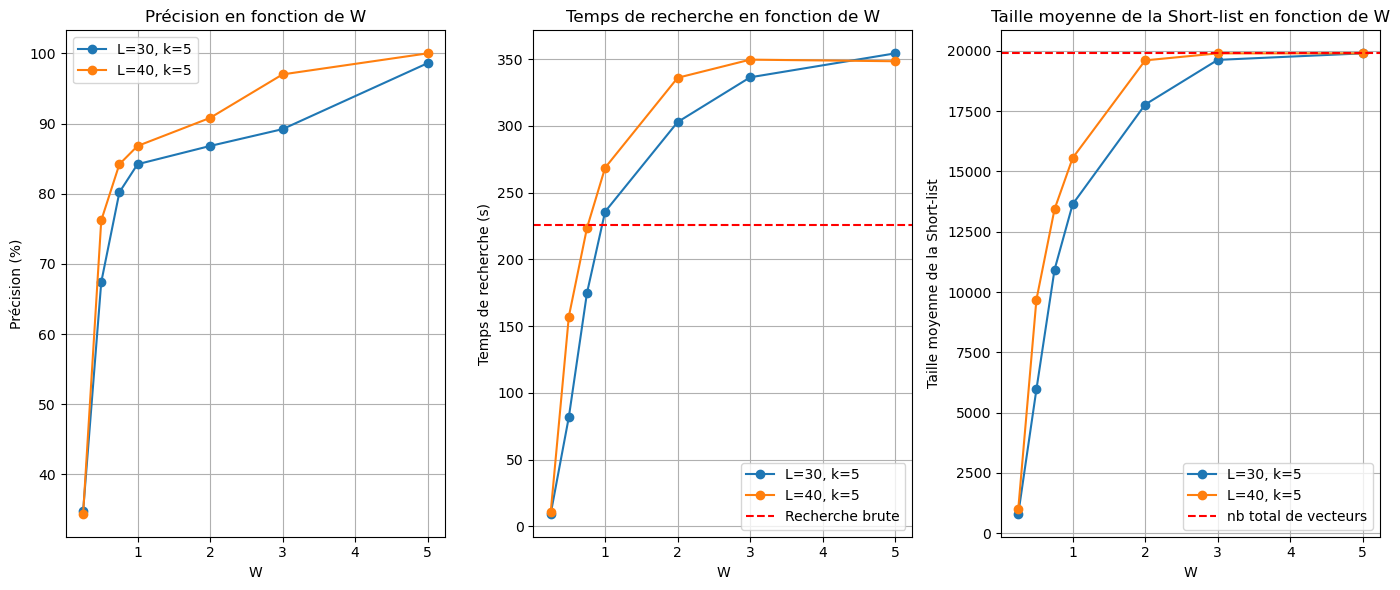

Ces deux graphiques qui représentent la précision et le temps de recherche en fonction du facteur w pour les configuration (30 projections, 5 tables) et (40 projections, 5 tables) permettent d'analyser les résultats et de déterminer les paramètres optimaux. 

On remarque pour les valeurs de w supérieures à 1 que le temps de recherche est supérieur a celui de la recherche par force brute, la méthode lsh n'a donc aucun intérêt pour ces configurations. 

En revanche pour des valeurs w trop faibles on perd beaucoup en précision. 

Nous avons vu précédement qu'un de nos problèmes était dans la taille des short list en effet le but de la méthode est d'obtenir grâce au hashage une liste bien plus faible que le nombre total de vecteurs sur laquelle réaliser la recherche brute-force, or dans de nombreuse configurations la taille moyenne des shorts list est trop élevée (donc proche du nombre total de vecteurs) pour que la méthode LSH soit efficace. 

In [ ]:
import matplotlib.pyplot as plt

# Filtrer les données pour chaque configuration
lsh_result_30_8 = lsh_result[(lsh_result['L'] == 30) & (lsh_result['k'] == 8)]
lsh_result_40_8 = lsh_result[(lsh_result['L'] == 40) & (lsh_result['k'] == 8)]

# Tracer la précision en fonction de W pour les configurations 30 projections / 5 tables et 40 projections / 5 tables
plt.figure(figsize=(14, 6))

# Précision pour L=30, k=8 et L=40, k=8
plt.subplot(1, 3, 1)
plt.plot(lsh_result_30_8['W'], lsh_result_30_8['Precision'],color='green', marker='o', label='L=30, k=8')
plt.plot(lsh_result_40_8['W'], lsh_result_40_8['Precision'],color='blue', marker='o', label='L=40, k=8')
plt.xlabel('W')
plt.ylabel('Précision (%)')
plt.title('Précision en fonction de W')
plt.legend()
plt.grid(True)

# Temps de recherche pour L=30, k=8 et L=40, k=8 
plt.subplot(1, 3, 2)
plt.plot(lsh_result_30_8['W'], lsh_result_30_8['Search Time (s)'],color='green', marker='o', label='L=30, k=8')
plt.plot(lsh_result_40_8['W'], lsh_result_40_8['Search Time (s)'],color='blue', marker='o', label='L=40, k=8')
plt.axhline(y=temps_de_recherche_force_brute, color='red', linestyle='--', label='Recherche brute')
plt.xlabel('W')
plt.ylabel('Temps de recherche (s)')
plt.title('Temps de recherche en fonction de W')
plt.legend()
plt.grid(True)

# Taille des short-list pour L=30, k=8 et L=40, k=8
plt.subplot(1, 3, 3)
plt.plot(lsh_result_30_8['W'], lsh_result_30_8['taille moyenne de la short-list'],color='green', marker='o', label='L=30, k=8')
plt.plot(lsh_result_40_8['W'], lsh_result_40_8['taille moyenne de la short-list'],color='blue', marker='o', label='L=40, k=8')

plt.axhline(y=19899, color='red', linestyle='--', label='nb total de vecteurs')
plt.xlabel('W')
plt.ylabel('Taille moyenne de la Short-list')
plt.title('Taille moyenne de la Short-list en fonction de W')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


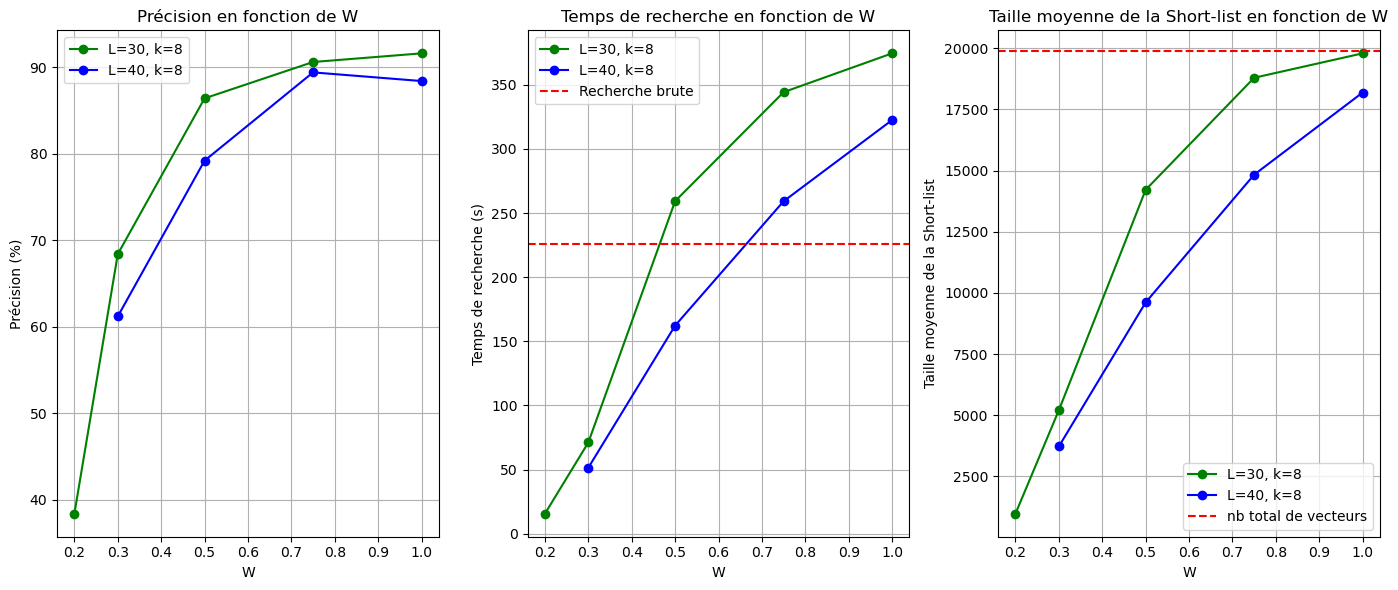

Ces deux graphiques qui représentent la précision et le temps de recherche en fonction du facteur w pour les configuration (30 projections, 8 tables) et (40 projections, 8 tables). Ici on a modifié le nombre de tables mais aucune amélioration n'est observée. On garde donc un nombre de table égale à 5.

En conclusion la configuration qui semble convenir est 40 projections 5 tables et une valeur de 0.75 pour W.

In [ ]:
# création des tables de hachages 

W_value = 0.75
nb_projections = 40
nb_tables = 5

lsh = LSH(nb_projections=nb_projections, nb_tables=nb_tables, w=W_value)

##### **6. Réduction de la dimension des données**

**6.1 Méthode d'Analyse des composants principales (ACP)**

On souhaite effectuer une réduction de dimension sur nos données (7275 dimensions) dans le but de simplifier leur structure tout en conservant les informations les plus importantes (inertie du nuages de points). Dans ce projet, nous avons appliqué dans un premier temps une réduction de dimension via l'Analyse en Composantes Principales (ACP), une méthode linéaire largement utilisée pour cette tâche. L'ACP permet de projeter les données dans un nouvel espace où les axes (ou composantes principales) correspondent aux directions de la plus grande variance des données.

Une ACP canonique a été choisie pour ce projet (variables homogènes et de même grandeur). Le processus se déroule en deux étapes principales :

- **Prétraitement des données** : les données d'origine *datavect_recipe* sont centrées en retirant la moyenne de chaque colonne pour obtenir une matrice de données centrées.

- **Application de l'ACP** : Nous avons initialement utilisé *PCA(n_components=7275)* pour calculer toutes les composantes principales. Ensuite, nous avons évalué le pourcentage d'inertie expliqué par chaque composante afin de déterminer le nombre optimal d'axes à conserver, en fonction de critères comme le critère de Kaiser (valeurs propres > moyenne(valeurs propres)) et la part d'inertie cumulée (environ 80 %).

Une fois ce nombre de composantes déterminé (587 composantes retenues ici), un nouveau modèle ACP (*new_pca*) est appliqué aux données pour obtenir une version projetée de ces dernières, réduite en dimensionnalité. Cette version simplifiée des données est ensuite utilisée pour accélérer les opérations de recherche des plus proches voisins à l'aide de la méthode force brute.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Prétraitement des données 

Y = datavect_small_recipe - np.mean(datavect_small_recipe, axis=0) 

# print(Y)
# print(Y.mean())
# print(Y.var())

Réalisation d'une première ACP pour déterminer le nombre de dimensions à conserver

In [ ]:
pca = PCA(n_components=7275)
pca.fit(Y)

In [ ]:
print("Vecteurs propres (composantes principales) :")
print(pca.components_)

valeurs_propres = pca.explained_variance_
print(f"\nValeurs propres : {valeurs_propres}")

valeurs_propres.shape

Utilisation du critère de Kaiser et de la part d'inertie expliquée pour determiner la valeur de n = nombre de dimensions à conserver.

In [ ]:
# Valeurs propres et pourcentages d'inertie
valeurs_propres = pca.explained_variance_
inertie_expliquee = pca.explained_variance_ratio_
inertie_cumulee = np.cumsum(inertie_expliquee)
inertie_totale = np.sum(valeurs_propres)

print(inertie_totale)

# Affichage des résultats
print("Valeurs propres (en ordre décroissant) :")
print(np.sort(valeurs_propres)[::-1])  # Affiche les valeurs propres en ordre décroissant

print("\nPourcentage d'inertie expliquée par chaque axe :")
for i, inertie in enumerate(inertie_expliquee):
    print(f"Axe {i + 1}: {inertie:.2%}")

print("\nPart d'inertie cumulée :")
for i, cumulee in enumerate(inertie_cumulee):
    print(f"Axe {i + 1}: {cumulee:.2%}")

# Tracé des courbes
plt.figure(figsize=(12, 6))

# Graphique des valeurs propres
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(valeurs_propres) + 1), np.sort(valeurs_propres)[::-1], marker='o')
plt.title("Valeurs propres")
plt.xlabel("Axes principaux")
plt.ylabel("Valeurs propres")
plt.xticks(np.arange(1, len(valeurs_propres) + 1))

# Graphique de la part d'inertie cumulée
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(inertie_cumulee) + 1), inertie_cumulee, marker='o', color='orange')
plt.title("Part d'inertie cumulée")
plt.xlabel("Axes principaux")
plt.ylabel("Part d'inertie cumulée")
plt.xticks(np.arange(1, len(inertie_cumulee) + 1))
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Critères pour déterminer le nombre d'axes à conserver
# Critère 1: Valeurs propres > 1 (Kaiser criterion)
axes_kept_kaiser = np.sum(valeurs_propres > inertie_totale/7275)
print(f"\nNombre d'axes à conserver selon le critère de Kaiser : {axes_kept_kaiser}")

# Critère 2: Cumulé > 80% (ou tout autre seuil)
axes_kept_cumule = np.sum(inertie_cumulee < 0.80)  # seuil à 80%
print(f"Nombre d'axes à conserver selon la part d'inertie cumulée > 80% : {axes_kept_cumule}")


On garde n=587 dimensions et on réalise une nouvelle ACP pour réduire la dimension des données.

In [ ]:
new_pca=PCA(n_components=587)
new_pca.fit(Y)

In [ ]:
# print(new_pca.explained_variance_)

y_vect_projetée = new_pca.transform(Y)
print(y_vect_projetée)

# print(Y.shape, y_vect_projetée.shape)

datavect_samll_recipe_acp = y_vect_projetée 

Ainsi datavect_samll_recipe_acp correspond à la matrice de recettes vectorisées grâce à une ACP avec 587 dimensions.

Force Brute sur le jeu de données de dimension réduite (pour tester visuellement la cohérence des plus proches voisins de la première recette)

In [ ]:
query_small_vect_acp = datavect_samll_recipe_acp[:100]
ds_small_vect_acp = datavect_samll_recipe_acp[100:]

query = query_small_vect_acp[0] 
metrics = ['euclidean','manhattan','chebyshev']
k_values=[1,3,5,10]
for m in metrics :
    for k in k_values :
        bf = NearestNeighbors(n_neighbors=k,algorithm='brute',metric=m)
        bf.fit(ds_small_vect_acp)
        dist,indices = bf.kneighbors([query])
        print(f"\nPour la distance '{m}', les {k} plus proches voisins de '{small_recipe.iloc[0]['title']}' sont :")
        print(small_recipe.iloc[100+indices[0]]["title"],dist[0])


On va maintenant récupérer les 5 plus proches voisins des 100 premières recettes par un calcul de force brute sur la matrice initiale (dimension 7275) et la matrice réduite (dimension 587) et donc comparer les résultats. On pourra conclure sur la précision et l'efficacité de cette méthode.

In [ ]:
distances_knn_force_brute = np.array([])
indices_knn_force_brute = np.array([])

for i in range(len(query_small_vect)) :
    query = query_small_vect[i]
    idx,distance = knn_search(ds_small_vect,query)
    distances_knn_force_brute = np.append(distances_knn_force_brute,distance)
    indices_knn_force_brute = np.append(indices_knn_force_brute,idx)
    
print(indices_knn_force_brute,len(indices_knn_force_brute))

In [ ]:
distances_knn_force_brute_acp= np.array([])
indices_knn_force_brute_acp = np.array([])

for i in range(len(query_small_vect_acp)) :
    query = query_small_vect_acp[i]
    idx,distance = knn_search(ds_small_vect_acp,query)
    distances_knn_force_brute_acp = np.append(distances_knn_force_brute_acp,[distance])
    indices_knn_force_brute_acp = np.append(indices_knn_force_brute_acp,[idx])

print(len(distances_knn_force_brute_acp),len(indices_knn_force_brute_acp))

On a : indices_knn_force_brute : liste des 500 indices, 5 plus proches voisins des 100 premières recettes
/ indices_knn_force_brute_acp : liste de 500 indices, 5 plus proches voisins des 100 premières recettes mais calcul réalisé sur la matrice de dimension réduite.

Pour le calcul de précision nous comptons pour chaque requête le nombre de plus proches voisins similaires dans chaque liste de 5 (pas de notion d'ordre). 



In [ ]:
x=0
indices_fb = np.array([indices_knn_force_brute[i:i+5] for i in range(0, len(indices_knn_force_brute), 5)])
indices_fb_acp = np.array([indices_knn_force_brute_acp[i:i+5] for i in range(0, len(indices_knn_force_brute_acp), 5)])

for i,j in zip(indices_fb_acp,indices_fb) : 
    for m in i :
        if m in j :
            x+=1
print(f"Précision = {x/500*100} %")

Conclusion sur l'efficacité de l'ACP : On trouve donc une précision proche de 80 %, ce qui reste tout à fait acceptable. En effet, en utilisant l'ACP, le temps de calcul des axes principaux et donc des dimensions à conserver n'est pas négligeable. Cependant, une fois l'ACP effectuée, la recherche des plus proches voisins est beaucoup plus courte (environ 8 fois plus rapide), ce qui est logique car nous avons réduit la dimension d'un facteur 12. En divisant par 2 le nombre initiale de dimensions, on arrive à une précision de 90 %, mais cela ne vaut pas vraiment le coup par rapport au temps d'exécution de l'ACP avec 3500 dimensions et au temps de recherche de force brute.

**6.2 Hashing trick**

On réalise exactement le même protocole pour calculer la précision de cette méthode.

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features=587)
datavect_hashing = vectorizer.transform(dataset_small_recipe)
print(datavect_hashing.toarray())

In [ ]:
datavect_samll_recipe_hashing = datavect_hashing.toarray()
print(datavect_samll_recipe_hashing, datavect_samll_recipe_hashing.shape)


In [ ]:
query_small_vect_hashing = datavect_samll_recipe_hashing[:100]
ds_small_vect_hashing = datavect_samll_recipe_hashing[100:]
print(query_small_vect_hashing.shape, ds_small_vect_hashing.shape)

In [ ]:
distances_knn_force_brute_hashing= np.array([])
indices_knn_force_brute_hashing = np.array([])

for i in range(len(query_small_vect_hashing)) : #100
    query = query_small_vect_hashing[i]
    idx,distance = knn_search(ds_small_vect_hashing,query)
    distances_knn_force_brute_hashing = np.append(distances_knn_force_brute_hashing,[distance])
    indices_knn_force_brute_hashing = np.append(indices_knn_force_brute_hashing,[idx])

print(len(distances_knn_force_brute_hashing),len(indices_knn_force_brute_hashing))

In [ ]:
x=0
indices_fb = np.array([indices_knn_force_brute[i:i+5] for i in range(0, len(indices_knn_force_brute), 5)])
indices_fb_hashing = np.array([indices_knn_force_brute_hashing[i:i+5] for i in range(0, len(indices_knn_force_brute_hashing), 5)])

for i,j in zip(indices_fb_hashing,indices_fb) : 
    for m in i :
        if m in j :
            x+=1
print(f"Précision = {x/500*100} %")

Conclusion sur Hashing Trick : Le temps de création de la matrice de recettes vectorisées est nettement plus rapide comparé à celui de l'ACP. Cependant, on a une précision de 42 %, que l'on estime pas suffisante. De plus, la précision ne varie presque pas en fonction du nombre de dimensions (on reste aux allentours de 43 % avec 7275 dimensions). Peut être que le problème provient de notre dataset_recipe (liste de recettes avec ingrédients + titre). Ainsi, cette méthode peut être intéressante pour un très gros jeu de données car création de la matrice très rapide mais précision pas suffisante. 

Dans notre contexte, pour ce type de jeu de données, nous privilégions la méthode en ACP, car elle allie précision et rapidité. 

##### **7. Test avec large recipe**

Pour terminer ce projet, nous souhaitions tester la recherche approximative avec LSH sur un jeu de données plus grand (large_recipe, 200 000 recettes) en utilisant les paramètres optimaux définis précédemment afin de démontrer l'utilité de la recherche approximative pour de grands jeux de données. Cependant, le volume de données était trop important pour nos machines, et nous n'avons pas réussi à obtenir un résultat. En effet, la première difficulté résidait dans la vectorisation des 200 000 recettes; notre approche initiale n'était pas suffisamment efficace. Pour remédier à cela, nous avons utilisé la méthode CountVectorizer, qui nous a permis de vectoriser l'ensemble des données. Nous avons ensuite pu créer un modèle LSH avec nos paramètres optimaux et l'entraîner sur notre jeu de données. Cependant, une fois de plus, nos machines n'ont pas réussi à exécuter la recherche de voisins par la méthode LSH, sans doute en raison de la dimension élevée des vecteurs (16 848). C'est pourquoi nous avons voulu utiliser une ACP pour réduire la dimension, mais, encore une fois, les données étaient trop volumineuses, et nous n'avons pas pu initialiser l'ACP pour déterminer le nombre de dimensions à conserver.

##### **8. Bilan et mise en perspective**

Nous avons apprécié travailler sur ce projet. En effet, à travers ce projet, nous avons pu mettre en pratique ce que nous avons appris en cours de Recherche par Similarité sur un exemple concret. Nous avons tout d'abord appris à vectoriser un jeu de données textuelles avec la méthode "Bag of Words" ainsi que toutes les étapes de modification des données pour mettre en oeuvre cette vectorisation. Puis nous avons appris à appliquer des algorithmes de recherche par similarité (force brute et LSH) ainsi que de trouver les paramètres optimaux pour LSH pour notre jeu de données. Nous avons aussi pu tester l'impact des méthodes de réduction de dimension avec ACP et Hashing. 

Malheureusement, nous avons pas pu mettre en oeuvre ces processus pour un jeu de données plus gros car nos machines ne nous le permettaient pas. Nous en concluant tout de même que l'utilisation d'une recherche approximative avec LSH, combiné avec une réduction de dimension en ACP peut être une très bonne alternative pour des jeux de données très volumineux, alliant une précision élevée (proche de la force brute) et un temps d'exécution nettement inférieur à celui d'une recherche par force brute. En effet, nous diminuons le nombre de calcul de distances grâce au hachage ainsi que le nombre de composantes dans chaque calcul de distance grâce à l'ACP. Le seul incovénient de cet méthode est de trouver les paramètres idéaux pour notre un jeu de données (paramètres LSH et nombre dimensions ACP), c'est à dire trouver le modèle qui convient le mieux. Mais, une fois ce modèle trouvé pour une application définie, les recherches sont précises et beaucoup plus rapides. Enfin, les défis ont principalement concerné la manipulation de grandes bases de données, où les dimensions importantes des vecteurs rendaient la recherche coûteuse en temps de calcul. Nous avons également rencontré des difficultés pour ajuster les paramètres de LSH afin de maintenir un bon équilibre entre la précision et la rapidité de la recherche. Puis nous avons aussi rencontré des difficultés lors de la vectorisation, afin de créer un vocabulaire précis et adapté au jeu de données (présence de caractères spéciaux notamment). 

Ce travail met en évidence le potentiel des méthodes de recherche de similarité et de réduction de dimensions dans le traitement de bases de données textuelles volumineuses. En contexte industriel, cette approche pourrait être appliquée à la recommandation de produits ou d'articles, offrant des résultats personnalisés et optimisés pour les utilisateurs. Pour aller plus loin, il aurait été intéressant d'intégrer une interface utilisateur qui permettrait une interaction directe avec l'algorithme. 
